# Прогнозирование оттока клиектов Телеком компании

**Цель: научиться прогнозировать отток клиентов**

**Описание проекта.**
<br>Телекомуникационная компания хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
    - `BeginDate` - дата заключения договора;
    - `EndDate` - дата расторжения договора;
    - `Type` - тип договора по периоду пролонгации;
    - `PaperlessBilling` - обмен документами без бумажных носителей;
    - `PaymentMethod` - способ оплаты;
    - `MonthlyCharges` - ежемесячные платёж в соответствии с тарифом;
    - `TotalCgarges` - общая сумма платежей;
- `personal.csv` — персональные данные клиента;
    - `gender` - информация о половой принадлежности;
    - `SeniorCitizen` - информация о том, является ли клиент пенсионером;
    - `Partner` - информации о том, состоит ли клиент в браке;
    - `Dependents` - информация о наличии детей;
- `internet.csv` — информация об интернет-услугах;
    - `InternetService` - тип подключения к сети интернет;
    - `OnlineSecurity` - подключение услуги блокировки небезопасных сайтов;
    - `OnlineBackup` - подключение облачного хранилища файлов для резервного копирования данных;
    - `DeviceProtection` - подключение антивируса;
    - `TechSupport` - подключение выделенной линии технической поддержки;
    - `StreamingTV` - подключение стримингового телевидения;
    - `StreamingMovies` - подключение каталога фильмов;
- `phone.csv` — информация об услугах телефонии
    - `MultipleLines` - подключение телефонного аппарата к нескольким линиям одновременно

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## Инструменты

**Импорт необходимых для проведения исследования библиотек**

In [ ]:
!pip install phik
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import time
from phik.report import plot_correlation_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.dummy import DummyClassifier

     |████████████████████████████████| 709 kB 1.2 MB/s eta 0:00:01


**Константы**

In [ ]:
RANDOM_STATE = 141122
REPORT_UPLOAD_DATE = '2020-02-01'

## Предобработка данных

**Загрузка датасетов и изучение их общей информации**

### Исследование `contract`

In [ ]:
contract = pd.read_csv('/datasets/final_provider/contract.csv')
display(contract.sample(5))
contract.info()

customerID   BeginDate EndDate            Type PaperlessBilling  \
6387  9853-JFZDU  2017-03-01      No  Month-to-month               No   
6653  8799-OXZMD  2017-10-01      No  Month-to-month              Yes   
2785  4016-BJKTZ  2018-01-01      No        Two year               No   
881   3523-BRGUW  2017-12-01      No        One year               No   
4953  1627-AFWVJ  2017-09-01      No        Two year               No   

                PaymentMethod  MonthlyCharges TotalCharges  
6387         Electronic check           56.85       1861.1  
6653             Mailed check           29.75        790.7  
2785         Electronic check          108.90      2809.05  
881   Credit card (automatic)           19.30        504.2  
4953             Mailed check           19.40       554.25

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Проверка наличия явных дубликатов

In [ ]:
contract.duplicated().sum()

0

Проверка уникальных значений в столбце `EndDate`

In [ ]:
contract['EndDate'].unique()

array(['No', '2019-12-01 00:00:00', '2019-11-01 00:00:00',
       '2019-10-01 00:00:00', '2020-01-01 00:00:00'], dtype=object)

Проверка уникальных значений в столбце `Type`

In [ ]:
contract['Type'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

Проверка уникальных значений в столбце `PaymentMethod`

In [ ]:
contract['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

Изменение типа данных в столбце `BeginDate`

In [ ]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')

Изменение типа данных в столбце `TotalCharges`

In [ ]:
#contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='raise' )
contract[contract['TotalCharges'] == ' ']['TotalCharges'].count()

11

Обнаружены пробелы в данных. Их всего 11. При изменении типа данных использую замену некорректных значений на `NaN`

In [ ]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce' )
contract['TotalCharges'] = contract['TotalCharges'].fillna(0)
contract[contract['TotalCharges'] == 0]

customerID  BeginDate EndDate      Type PaperlessBilling  \
488   4472-LVYGI 2020-02-01      No  Two year              Yes   
753   3115-CZMZD 2020-02-01      No  Two year               No   
936   5709-LVOEQ 2020-02-01      No  Two year               No   
1082  4367-NUYAO 2020-02-01      No  Two year               No   
1340  1371-DWPAZ 2020-02-01      No  Two year               No   
3331  7644-OMVMY 2020-02-01      No  Two year               No   
3826  3213-VVOLG 2020-02-01      No  Two year               No   
4380  2520-SGTTA 2020-02-01      No  Two year               No   
5218  2923-ARZLG 2020-02-01      No  One year              Yes   
6670  4075-WKNIU 2020-02-01      No  Two year               No   
6754  2775-SEFEE 2020-02-01      No  Two year              Yes   

                  PaymentMethod  MonthlyCharges  TotalCharges  
488   Bank transfer (automatic)           52.55           0.0  
753                Mailed check           20.25           0.0  
936                Mailed check           80.85           0.0  
1082               Mailed check           25.75           0.0  
1340    Credit card (automatic)           56.05           0.0  
3331               Mailed check           19.85           0.0  
3826               Mailed check           25.35           0.0  
4380               Mailed check           20.00           0.0  
5218               Mailed check           19.70           0.0  
6670               Mailed check           73.35           0.0  
6754  Bank transfer (automatic)           61.90           0.0

Дата заключения договора с клиентами, от которых не поступало платежей, `2020-02-01` - совпадает с датой выгрузки отчёта. Похоже, что они на самом деле пока не успели ничего оплатить. Учитывая их количество, этими данными можно пренебречь.

In [ ]:
contract = contract.loc[contract['TotalCharges'] != 0]

Замена значения `No` на дату выгрузки отчёта и изменение типа данных в `EndDate`

In [ ]:
contract['EndDate'] = contract['EndDate'].replace('No', REPORT_UPLOAD_DATE)
contract['EndDate'] = pd.to_datetime(contract['EndDate'], format='%Y-%m-%d')

Изменение типа данных в `PaperlessBilling`

In [ ]:
display(contract['PaperlessBilling'].unique())
contract['PaperlessBilling'] = contract['PaperlessBilling'].replace('Yes', 1)
contract['PaperlessBilling'] = contract['PaperlessBilling'].replace('No', 0)

array(['Yes', 'No'], dtype=object)

Для категоризации целевого признака создам функцию `outflow_category`. На вход принимает значения столбца `EndDate`, возвращает 1 при наличии даты расторжения договора, либо 0, если договор действует.

In [ ]:
def outflow_category(row):
    end_date = row['EndDate']
    
    try:
        if end_date == pd.Timestamp(REPORT_UPLOAD_DATE):
            return 0
        return 1
    except:
        display('Введено некорректное значение')
        
contract['outflow_category'] = contract.apply(outflow_category, axis=1)
contract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   datetime64[ns]
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   int64         
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   outflow_category  7032 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(3)
memory usage: 549.4+ KB


Введение нового признака `contract_duration` - это разница между датой расторжения договора и датой его заключения

In [ ]:
contract['contract_duration'] = (pd.Timestamp(REPORT_UPLOAD_DATE) - contract['BeginDate']).dt.days
contract.sample(5)

customerID  BeginDate    EndDate            Type  PaperlessBilling  \
3936  0701-TJSEF 2019-05-01 2020-02-01  Month-to-month                 1   
6276  5003-OKNNK 2018-11-01 2020-02-01        One year                 0   
4372  4781-ZXYGU 2020-01-01 2020-02-01  Month-to-month                 1   
1564  2660-EMUBI 2018-12-01 2019-10-01  Month-to-month                 1   
6618  8404-FYDIB 2017-12-01 2020-02-01  Month-to-month                 1   

                  PaymentMethod  MonthlyCharges  TotalCharges  \
3936  Bank transfer (automatic)           68.25        576.95   
6276    Credit card (automatic)           20.35        335.95   
4372  Bank transfer (automatic)           20.15         20.15   
1564           Electronic check           95.35        898.35   
6618    Credit card (automatic)           86.65       2208.75   

      outflow_category  contract_duration  
3936                 0                276  
6276                 0                457  
4372                 0                 31  
1564                 1                427  
6618                 0                792

**Выводы:**
- явных дубликатов не обнаружено
- изменён тип данных в `TotalCharges` на `float`
- изменён тип данных в `BeginDate` и `EndDate` на `DateTime`
- изменён тип данных в `PaperlessBilling` на `int64`
- **целевой признак находится в `outflow_category`**
- категоризацию данных в `Type` и `PaymentMethod` сделаем после разделения общего датафрейма на выборки
- удалены пропуски в `TotalCharges`
- добавлен признак `contract_duration`

### Исследование `personal`

In [ ]:
personal = pd.read_csv('/datasets/final_provider/personal.csv')
display(personal.sample(5))
personal.info()

customerID  gender  SeniorCitizen Partner Dependents
6580  7696-AMHOD  Female              0     Yes        Yes
5905  1628-BIZYP    Male              0      No         No
6440  2809-ZMYOQ  Female              0      No         No
1590  7643-RCHXS  Female              0     Yes        Yes
4745  6116-RFVHN  Female              0     Yes         No

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Проверка на наличие явнях дубликатов

In [ ]:
personal.duplicated().sum()

0

Изменение типа данных в `Partner` и `Dependents`

In [ ]:
personal['Partner'] = personal['Partner'].replace('Yes', 1)
personal['Partner'] = personal['Partner'].replace('No', 0)
personal['Dependents'] = personal['Dependents'].replace('Yes', 1)
personal['Dependents'] = personal['Dependents'].replace('No', 0)
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   int64 
 4   Dependents     7043 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 275.2+ KB


**Выводы:**
- пропусков в наборе данных не обнаружено
- явных дубликатов не обнаружено
- в `Partner` и `Dependents` заменены типы данных
- произвести категоризацию данных в `gender`сделаем после разделения общего датафрейма на выборки

### Исследование `internet`

In [ ]:
internet = pd.read_csv('/datasets/final_provider/internet.csv')
display(internet.sample(5))
internet.info()

customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
4773  6218-KNUBD             DSL             No          Yes               No   
1398  7279-BUYWN     Fiber optic            Yes          Yes              Yes   
5466  6447-GORXK             DSL             No           No               No   
4725  4884-ZTHVF     Fiber optic             No          Yes               No   
1861  5103-MHMHY             DSL             No           No               No   

     TechSupport StreamingTV StreamingMovies  
4773          No         Yes              No  
1398          No         Yes             Yes  
5466          No          No              No  
4725          No         Yes              No  
1861          No          No              No

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Проверка наличия явных дубликатов

In [ ]:
internet.duplicated().sum()

0

Изменение типа данных в колонках

In [ ]:
for col in ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']:
    internet[col] = (internet[col] == 'Yes').astype('int8')

Добавление нового столбца для идентификации пользователей интернета

In [ ]:
internet.insert(1, 'internet_available', 1)

**Выводы:**
- данных в датасете на 20% меньше, чем в предыдущих
- пропусков не наблюдается
- дубликатов не обнаружено
- произвести категоризацию в `InternetService` сделаем после разделения общего датафрейма на выборки
- в колонках изменён тип данных на `int`
- добавлен признак `internet_available`, указывающий на подключение к всемирной сети

### Исследование `phone`

In [ ]:
phone = pd.read_csv('/datasets/final_provider/phone.csv')
display(phone.sample(5))
phone.info()

customerID MultipleLines
3123  0428-AXXLJ            No
1299  6510-UPNKS           Yes
2196  1089-HDMKP            No
4739  8044-BGWPI            No
1898  7746-QYVCO            No

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Проверка наличия явных дубликатов

In [ ]:
phone.duplicated().sum()

0

Изменение типа данных в `MultipleLines`

In [ ]:
phone['MultipleLines'] = (phone['MultipleLines'] == 'Yes').astype('int8')

Добавление нового столбца для идентификации пользователей этой услуги

In [ ]:
phone.insert(1, 'phone_available', 1)

**Выводы:**
- пропусков в датасете не наблюдается
- дубликатов не обнаружено
- изменён тип данных в `MultipleLines`
- добавлен признак `phone_available`, указывающий на подключение услуги телефонии

### Примерный план решения задачи

 - Предобработка данных
    
- Объединение датафреймов, исследование общей таблицы
    
- Разделение на выборки (`test_size = 25%`)
    
- Применение техник кодирования с учётом моделей, которые будут использованы
    
- Масштабирование данных (при необходимости)
    
- Обучение трёх моделей на тренировочной выборке (подбор гиперпараметров)
    
- Выбор оптимальной модели (по результатам кросс-валидации, метрика `ROC-AUC`)
    
- Проверка качества лучшей модели на тестовой выборке (три метрики: `ROC-AUC`, `Recall`, `Precision`), формирование матрицы ошибок и выявление важности признаков
    
- Отчёт

## Объединение датафреймов

Для объединения использую метод `merge` с сохранением данных из файла `contract`

In [ ]:
joint_df = (
    contract.merge(personal, how='left', left_on='customerID', right_on='customerID')
    .merge(internet, how='left', left_on='customerID', right_on='customerID')
    .merge(phone, how='left', left_on='customerID', right_on='customerID')
)

Проверка результата объединения

In [ ]:
joint_df.sample(5)

customerID  BeginDate    EndDate            Type  PaperlessBilling  \
5462  3002-WQZWT 2017-09-01 2020-02-01  Month-to-month                 1   
1226  0178-SZBHO 2016-03-01 2020-02-01  Month-to-month                 0   
6118  6198-PNNSZ 2015-06-01 2020-02-01        One year                 0   
2836  9743-DQKQW 2019-11-01 2020-02-01  Month-to-month                 0   
2237  3378-AJRAO 2016-06-01 2020-02-01        One year                 0   

                  PaymentMethod  MonthlyCharges  TotalCharges  \
5462           Electronic check           74.20       1993.25   
1226           Electronic check           87.20       4017.45   
6118  Bank transfer (automatic)          109.80       6109.65   
2836           Electronic check           25.10         79.80   
2237           Electronic check           24.85       1013.60   

      outflow_category  contract_duration  ... internet_available  \
5462                 0                883  ...                1.0   
1226                 0               1432  ...                1.0   
6118                 0               1706  ...                1.0   
2836                 0                 92  ...                1.0   
2237                 0               1340  ...                NaN   

      InternetService  OnlineSecurity  OnlineBackup  DeviceProtection  \
5462      Fiber optic             0.0           0.0               0.0   
1226      Fiber optic             0.0           1.0               0.0   
6118      Fiber optic             1.0           1.0               1.0   
2836              DSL             0.0           0.0               0.0   
2237              NaN             NaN           NaN               NaN   

     TechSupport  StreamingTV  StreamingMovies  phone_available  MultipleLines  
5462         0.0          0.0              0.0              1.0            1.0  
1226         0.0          1.0              0.0              1.0            1.0  
6118         0.0          1.0              1.0              1.0            1.0  
2836         0.0          0.0              0.0              NaN            NaN  
2237         NaN          NaN              NaN              1.0            1.0  

[5 rows x 24 columns]

В присоединённых данных из таблиц `internet` и `phone` ожидаемо появились пропуски. Проверка распределения пользователей услуг связи по целевому признаку без учёта пропусков.

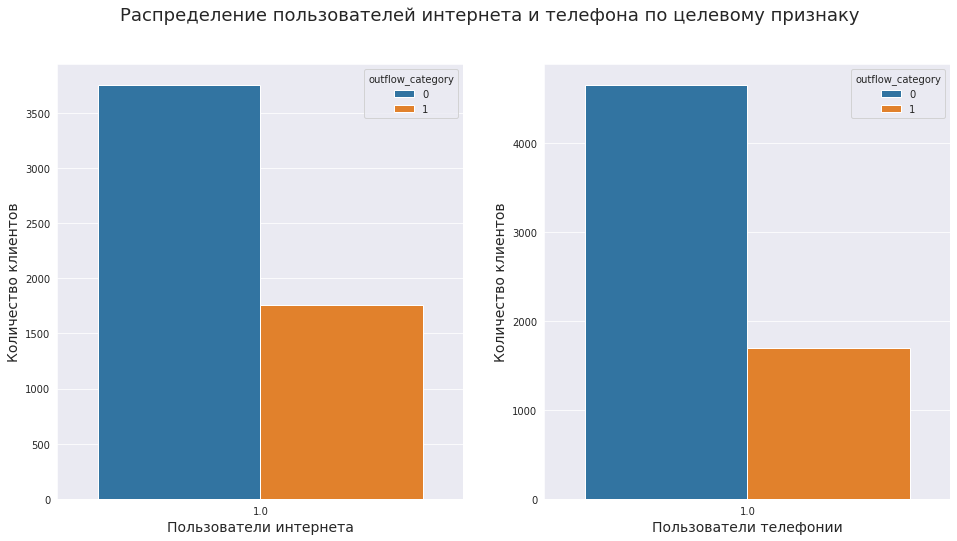

In [ ]:
sns.set_style('darkgrid')
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True)
fig.suptitle('Распределение пользователей интернета и телефона по целевому признаку', fontsize=18)

sns.countplot(ax=axes[0], data=joint_df, hue='outflow_category', x='internet_available')
axes[0].set_xlabel('Пользователи интернета', fontsize=14)
axes[0].set_ylabel('Количество клиентов', fontsize=14)

sns.countplot(ax=axes[1], data=joint_df, hue='outflow_category', x='phone_available')
axes[1].set_xlabel('Пользователи телефонии', fontsize=14)
axes[1].set_ylabel('Количество клиентов', fontsize=14)

plt.show()

Среди пользователей интернета почти половина расторгла договор, среди пользователей телефонных услуг расторгла договор примерно треть клиентов.

Сделаю допущение: пропуски означают, что клиент услугой не пользовался. Проверка распределения пользователей услуг связи по целевому признаку с учётом пропусков (заполнены нулями).

In [ ]:
joint_df[(internet.drop('InternetService', axis=1)).columns] = (
    joint_df[(internet.drop('InternetService', axis=1)).columns].fillna(0)
)
joint_df['InternetService'] = joint_df['InternetService'].fillna('No')
joint_df[phone.columns] = joint_df[phone.columns].fillna(0)

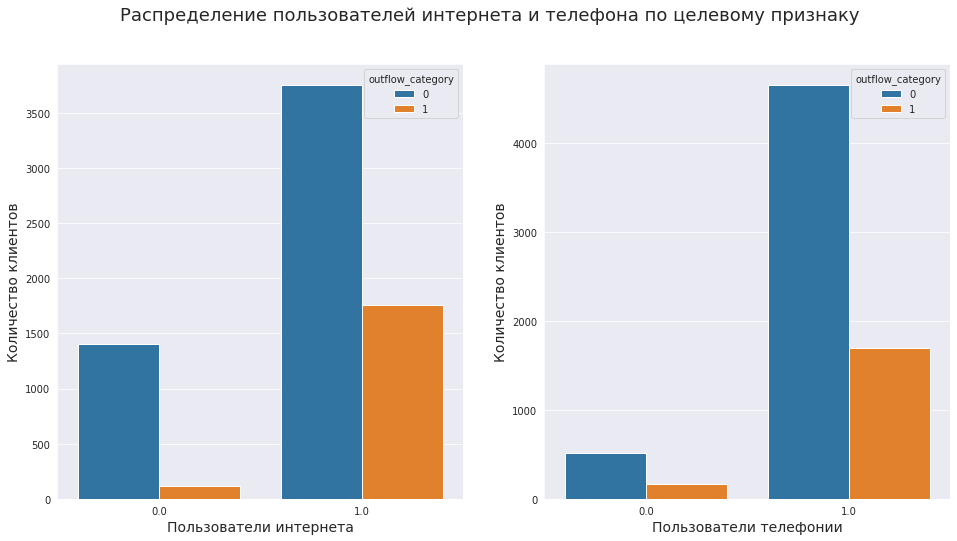

In [ ]:
sns.set_style('darkgrid')
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Распределение пользователей интернета и телефона по целевому признаку', fontsize=18)

sns.countplot(ax=axes[0], data=joint_df, hue='outflow_category', x='internet_available')
axes[0].set_xlabel('Пользователи интернета', fontsize=14)
axes[0].set_ylabel('Количество клиентов', fontsize=14)

sns.countplot(ax=axes[1], data=joint_df, hue='outflow_category', x='phone_available')
axes[1].set_xlabel('Пользователи телефонии', fontsize=14)
axes[1].set_ylabel('Количество клиентов', fontsize=14)

plt.show()

При условии принятия допущения соотношение практически не меняется.

Построение тепловой диаграммы для количественных признаков, чтобы обнаружить наличие линейных связей между ними.

In [ ]:
interval_cols = ['PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 
                                    'outflow_category', 'contract_duration', 'SeniorCitizen', 
                                    'internet_available', 'phone_available']
phik_overview = joint_df[interval_cols].phik_matrix()

interval columns not set, guessing: ['PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'outflow_category', 'contract_duration', 'SeniorCitizen', 'internet_available', 'phone_available']


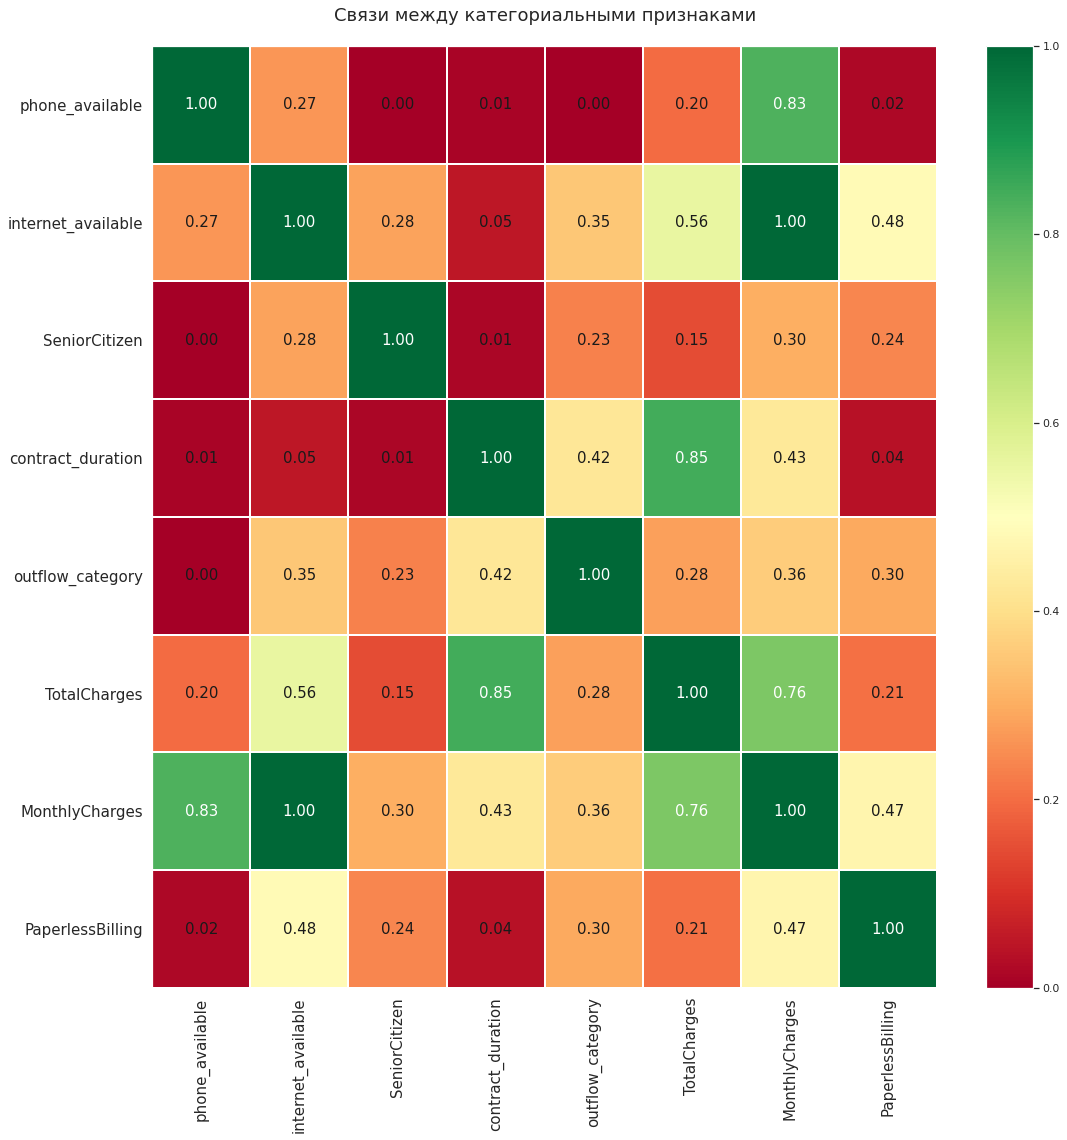

In [ ]:
sns.set()
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, 
                        fontsize_factor=1.5, 
                        figsize=(16, 16))

plt.title('Связи между категориальными признаками', fontsize=18, y=1.02)
plt.tight_layout()

Заключения о связях признаков по тепловой диаграмме `phik`:
- у признака `MonthlyCharges` наблюдается высокая связь с `phone_available`, `internet_available` и `TotalCharges`
- `contract_duration` коррелирует с `TotalCharges`
- между остальными признаками зависимостей не прослеживается

### Выводы:
- датафреймы объединены;
- пропуски в объединённой таблице обработаны;
- корелляция между признаками изучена.

## Подготовка данных к обучению моделей

Для обучения выбраны три модели:
- Модель случайного леса
- Модель линейной регрессии
- Модель градиентного бустинга `CatBoost`

### Разделение данных на обучающую и тестовую выборки

Выделение целевого признака, удаление ненужных признаков

In [ ]:
X = joint_df.drop(['customerID', 'BeginDate', 'EndDate', 'outflow_category'], axis=1)
y = joint_df['outflow_category']
display('Размеры выборок')
X.shape, y.shape

'Размеры выборок'

((7032, 20), (7032,))

Разделение на выборки с учётом баланса классов в целевом признаке

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=RANDOM_STATE, stratify=y)
display('Размеры выборок')
X_train.shape, X_test.shape, y_train.shape, y_test.shape

'Размеры выборок'

((5274, 20), (1758, 20), (5274,), (1758,))

### Кодирование данных

Выделение категориальных и количественных признаков

In [ ]:
cat_features = ['Type', 'PaymentMethod', 'gender', 'InternetService']
quanti_features = ['MonthlyCharges', 'TotalCharges', 'contract_duration']

Применение `OneHotEncoder`, чтобы привести данные к виду, подходящему для обучения линейной модели

In [ ]:
ohe = OneHotEncoder(categories='auto', drop='first', handle_unknown='error', sparse = False)
ohe.fit(X_train[cat_features])

X_train_ohe = (
    pd.DataFrame(ohe.transform(X_train[cat_features]), 
                 columns=ohe.get_feature_names(input_features=None), index=X_train.index)
    .merge(X_train.drop(cat_features, axis=1), left_index=True, right_index=True)
)


X_test_ohe = (
    pd.DataFrame(ohe.transform(X_test[cat_features]), 
                 columns=ohe.get_feature_names(input_features=None), index=X_test.index)
    .merge(X_test.drop(cat_features, axis=1), left_index=True, right_index=True)
)

display(X_train_ohe.sample(3))
X_test_ohe.sample(3)

x0_One year  x0_Two year  x1_Credit card (automatic)  \
3628          0.0          1.0                         0.0   
2214          0.0          0.0                         0.0   
570           0.0          1.0                         0.0   

      x1_Electronic check  x1_Mailed check  x2_Male  x3_Fiber optic  x3_No  \
3628                  0.0              0.0      1.0             1.0    0.0   
2214                  1.0              0.0      1.0             1.0    0.0   
570                   0.0              0.0      1.0             0.0    0.0   

      PaperlessBilling  MonthlyCharges  ...  Dependents  internet_available  \
3628                 0          113.80  ...           0                 1.0   
2214                 0           89.95  ...           0                 1.0   
570                  0           59.60  ...           0                 1.0   

      OnlineSecurity  OnlineBackup  DeviceProtection  TechSupport  \
3628             1.0           1.0               1.0          1.0   
2214             0.0           0.0               0.0          0.0   
570              0.0           1.0               0.0          1.0   

      StreamingTV  StreamingMovies  phone_available  MultipleLines  
3628          1.0              1.0              1.0            1.0  
2214          1.0              1.0              1.0            0.0  
570           0.0              0.0              1.0            1.0  

[3 rows x 24 columns]

x0_One year  x0_Two year  x1_Credit card (automatic)  \
2305          0.0          1.0                         0.0   
337           0.0          1.0                         0.0   
6376          0.0          0.0                         0.0   

      x1_Electronic check  x1_Mailed check  x2_Male  x3_Fiber optic  x3_No  \
2305                  0.0              0.0      1.0             0.0    0.0   
337                   1.0              0.0      0.0             0.0    0.0   
6376                  1.0              0.0      1.0             1.0    0.0   

      PaperlessBilling  MonthlyCharges  ...  Dependents  internet_available  \
2305                 1           63.70  ...           0                 1.0   
337                  1           88.15  ...           0                 1.0   
6376                 1          101.70  ...           1                 1.0   

      OnlineSecurity  OnlineBackup  DeviceProtection  TechSupport  \
2305             1.0           1.0               1.0          1.0   
337              1.0           1.0               1.0          1.0   
6376             0.0           1.0               0.0          0.0   

      StreamingTV  StreamingMovies  phone_available  MultipleLines  
2305          1.0              1.0              0.0            0.0  
337           1.0              1.0              1.0            1.0  
6376          1.0              1.0              1.0            1.0  

[3 rows x 24 columns]

Масштабирование данных при помощи `StandardScaler` для корректного обучения линейной модели. Написание функции: на вход принимает признаки, возвращает масштабированные признаки.

In [ ]:
def scaling(features_train, features_test):
    scaler = StandardScaler()
    scaler.fit(features_train[quanti_features])
    features_scaled_train = (pd.DataFrame(scaler.transform(features_train[quanti_features]), 
                                          columns=quanti_features, index=features_train.index)
                             .merge(features_train.drop(quanti_features, axis=1), left_index=True, right_index=True)
                            )
    features_scaled_test = (pd.DataFrame(scaler.transform(features_test[quanti_features]), 
                                    columns=quanti_features, index=features_test.index)
                            .merge(features_test.drop(quanti_features, axis=1), left_index=True, right_index=True)
                      )
    return features_scaled_train, features_scaled_test

Применение функции к выборкам.

In [ ]:
X_train_scaled, X_test_scaled = scaling(X_train_ohe, X_test_ohe)
display(X_train_scaled.sample(3))
X_test_scaled.sample(3)

MonthlyCharges  TotalCharges  contract_duration  x0_One year  \
278        -0.323330     -0.663260          -0.784845          0.0   
1925       -1.469772     -0.969081          -1.237726          0.0   
5535        1.396334      1.748524           1.148349          0.0   

      x0_Two year  x1_Credit card (automatic)  x1_Electronic check  \
278           0.0                         0.0                  1.0   
1925          0.0                         0.0                  1.0   
5535          0.0                         0.0                  1.0   

      x1_Mailed check  x2_Male  x3_Fiber optic  ...  Dependents  \
278               0.0      1.0             0.0  ...           0   
1925              0.0      1.0             0.0  ...           0   
5535              0.0      1.0             1.0  ...           0   

      internet_available  OnlineSecurity  OnlineBackup  DeviceProtection  \
278                  1.0             0.0           0.0               1.0   
1925                 0.0             0.0           0.0               0.0   
5535                 1.0             1.0           1.0               1.0   

      TechSupport  StreamingTV  StreamingMovies  phone_available  \
278           1.0          1.0              1.0              0.0   
1925          0.0          0.0              0.0              1.0   
5535          1.0          1.0              0.0              1.0   

      MultipleLines  
278             0.0  
1925            0.0  
5535            1.0  

[3 rows x 24 columns]

MonthlyCharges  TotalCharges  contract_duration  x0_One year  \
4452        0.447611     -0.356647          -0.619915          0.0   
3264       -1.326882     -0.298475           1.313279          1.0   
6417       -0.487819     -0.110098           0.325051          1.0   

      x0_Two year  x1_Credit card (automatic)  x1_Electronic check  \
4452          0.0                         0.0                  1.0   
3264          0.0                         1.0                  0.0   
6417          0.0                         0.0                  0.0   

      x1_Mailed check  x2_Male  x3_Fiber optic  ...  Dependents  \
4452              0.0      1.0             1.0  ...           0   
3264              0.0      1.0             0.0  ...           0   
6417              0.0      0.0             0.0  ...           0   

      internet_available  OnlineSecurity  OnlineBackup  DeviceProtection  \
4452                 1.0             0.0           0.0               1.0   
3264                 0.0             0.0           0.0               0.0   
6417                 1.0             0.0           0.0               0.0   

      TechSupport  StreamingTV  StreamingMovies  phone_available  \
4452          1.0          0.0              0.0              1.0   
3264          0.0          0.0              0.0              1.0   
6417          1.0          0.0              0.0              1.0   

      MultipleLines  
4452            0.0  
3264            1.0  
6417            0.0  

[3 rows x 24 columns]

Применение техники `ordinal encoding`, чтобы привести данные к виду, подходящему для обучения леса. Написание функции для преобразования данных: на вход принимает датафрейм признаков, возвращает датафрейм с кодированными признаками.

In [ ]:
def ordinal_encoding(features_train, features_test):
    encoder = OrdinalEncoder()
    encoder.fit(features_train[cat_features])
    
    features_train_oe = pd.DataFrame(encoder.transform(features_train[cat_features]), 
                                     columns=cat_features, index=features_train.index)
    features_train_oe = features_train_oe.merge(features_train.drop(cat_features, axis=1), 
                                                left_index=True, right_index=True)
    
    features_test_oe = pd.DataFrame(encoder.transform(features_test[cat_features]), 
                                    columns=cat_features, index=features_test.index)
    features_test_oe = features_test_oe.merge(features_test.drop(cat_features, axis=1), 
                                              left_index=True, right_index=True)
    
    return features_train_oe, features_test_oe

Применение функции к датафреймам с выборками.

In [ ]:
X_train_oe, X_test_oe = ordinal_encoding(X_train, X_test)
display(X_train_oe.sample(3))
X_test_oe.sample(3)

Type  PaymentMethod  gender  InternetService  PaperlessBilling  \
1188   0.0            2.0     1.0              1.0                 1   
6165   0.0            2.0     1.0              0.0                 1   
6139   2.0            3.0     0.0              0.0                 1   

      MonthlyCharges  TotalCharges  contract_duration  SeniorCitizen  Partner  \
1188           90.45        593.45                337              0        0   
6165           29.65        118.50                215              0        0   
6139           66.90       4577.90               2102              0        0   

      Dependents  internet_available  OnlineSecurity  OnlineBackup  \
1188           0                 1.0             0.0           0.0   
6165           0                 1.0             0.0           0.0   
6139           0                 1.0             1.0           1.0   

      DeviceProtection  TechSupport  StreamingTV  StreamingMovies  \
1188               1.0          0.0          1.0              0.0   
6165               1.0          0.0          0.0              0.0   
6139               0.0          1.0          0.0              0.0   

      phone_available  MultipleLines  
1188              1.0            1.0  
6165              0.0            0.0  
6139              1.0            1.0

Type  PaymentMethod  gender  InternetService  PaperlessBilling  \
6664   0.0            3.0     1.0              2.0                 0   
1217   0.0            3.0     1.0              0.0                 1   
328    0.0            2.0     0.0              0.0                 1   

      MonthlyCharges  TotalCharges  contract_duration  SeniorCitizen  Partner  \
6664            23.5        173.00                215              0        0   
1217            24.6        190.10                276              0        0   
328             35.9        973.65                853              1        1   

      Dependents  internet_available  OnlineSecurity  OnlineBackup  \
6664           0                 0.0             0.0           0.0   
1217           0                 1.0             0.0           0.0   
328            1                 1.0             0.0           0.0   

      DeviceProtection  TechSupport  StreamingTV  StreamingMovies  \
6664               0.0          0.0          0.0              0.0   
1217               0.0          0.0          0.0              0.0   
328                0.0          0.0          1.0              0.0   

      phone_available  MultipleLines  
6664              1.0            1.0  
1217              0.0            0.0  
328               0.0            0.0

### Выводы:
- Для корректного обучения линеной модели данные преобразованы с помощью `OneHotEncoder` и `StandardScaler`
- Для корректного обучения модели случайного леса к данным применена техника порядкового кодирования `ordinal encoding`
- Данные подготовлены к использованию в обучении

## Обучение моделей

### Обучение модели логистической регрессии

In [ ]:
%time

params_lr = {"class_weight": ['balanced'], 
             "max_iter": [100, 150, 200],
             "C": [0.5, 1.0, 1.5]
            }
model_lr = LogisticRegression(random_state=RANDOM_STATE)
model_lr_gs = GridSearchCV(model_lr, cv=3, scoring='roc_auc', param_grid=params_lr, verbose=1)
model_lr_gs.fit(X_train_scaled, y_train)

display('Лучший результат ROC-AUC:', model_lr_gs.best_score_)
display('Лучшие параметры:', model_lr_gs.best_params_)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs
Fitting 3 folds for each of 9 candidates, totalling 27 fits


'Лучший результат ROC-AUC:'

0.8358130018565872

'Лучшие параметры:'

{'C': 1.0, 'class_weight': 'balanced', 'max_iter': 100}

### Обучение модели случайного леса

In [ ]:
%%time

params_rfc = {"max_depth": [15, 20, 25], 
              "n_estimators": [300, 350, 500], 
              "criterion": ['gini', 'entropy'], 
              "class_weight": ['balanced']
         }
model_rfc = RandomForestClassifier(random_state=RANDOM_STATE)

model_rfc_gs = GridSearchCV(model_rfc, cv=3, scoring='roc_auc', param_grid=params_rfc, verbose=1)
model_rfc_gs.fit(X_train_oe, y_train)

display('Лучший результат ROC-AUC:', model_rfc_gs.best_score_)
display('Лучшие параметры:', model_rfc_gs.best_params_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


'Лучший результат ROC-AUC:'

0.8785671025857963

'Лучшие параметры:'

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 15,
 'n_estimators': 500}

CPU times: user 1min 20s, sys: 918 ms, total: 1min 21s
Wall time: 1min 24s


### Обучение модели градиентного бустинга

In [ ]:
%%time

params_cb = {"max_depth": [1, 2, 3], 
             "learning_rate": [0.87, 0.88, 0.89], 
             "n_estimators": [650, 700, 750], 
             "auto_class_weights": ['Balanced'], 
             "l2_leaf_reg": [8, 9, 10]
         }
model_cbc = CatBoostClassifier(random_state=RANDOM_STATE, eval_metric='AUC', loss_function='Logloss')

model_cbc_gs = model_cbc.grid_search(params_cb, Pool(X_train, y_train, cat_features=cat_features), verbose=False, cv=3, plot=True)

display('Лучшие параметры:', model_cbc.get_all_params())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7275410	best: 0.7275410 (0)	total: 50.2ms	remaining: 32.6s
1:	test: 0.7769672	best: 0.7769672 (1)	total: 53ms	remaining: 17.2s
2:	test: 0.7985623	best: 0.7985623 (2)	total: 55ms	remaining: 11.9s
3:	test: 0.8156515	best: 0.8156515 (3)	total: 57.6ms	remaining: 9.3s
4:	test: 0.8348232	best: 0.8348232 (4)	total: 60.1ms	remaining: 7.75s
5:	test: 0.8312471	best: 0.8348232 (4)	total: 62.4ms	remaining: 6.7s
6:	test: 0.8351642	best: 0.8351642 (6)	total: 65ms	remaining: 5.97s
7:	test: 0.8407886	best: 0.8407886 (7)	total: 67.1ms	remaining: 5.38s
8:	test: 0.8462857	best: 0.8462857 (8)	total: 69.2ms	remaining: 4.92s
9:	test: 0.8549679	best: 0.8549679 (9)	total: 71.4ms	remaining: 4.57s
10:	test: 0.8607946	best: 0.8607946 (10)	total: 73.8ms	remaining: 4.29s
11:	test: 0.8649959	best: 0.8649959 (11)	total: 75.9ms	remaining: 4.03s
12:	test: 0.8677308	best: 0.8677308 (12)	total: 78ms	remaining: 3.82s
13:	test: 0.8699337	best: 0.8699337 (13)	total: 80.1ms	remaining: 3.64s
14:	test: 0.8722071	be

'Лучшие параметры:'

{'nan_mode': 'Min',
 'eval_metric': 'AUC',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 700,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 9,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.

CPU times: user 3min 4s, sys: 8.24 s, total: 3min 13s
Wall time: 3min 17s


### Выводы:
- на модели `LogisticRegression` удалось получить `ROC-AUC` = 0.83
- при обучении модели `RandomForestClassifier` `ROC-AUC` = 0.87
- модель `CatBoostClassifier` показала лучший результат метрики: `ROC-AUC` = 0.93

## Проверка качества модели на тестовой выборке

In [ ]:
predict = model_cbc.predict_proba(X_test)[:, 1]
'Получен результат ROC-AUC:', roc_auc_score(y_test, predict)

('Получен результат ROC-AUC:', 0.9542956757124351)

Сравнение результатов выбранной модели с результатами простейшей модели для проверки адекватности предсказаний

In [ ]:
dummy_model = DummyClassifier(strategy='uniform', random_state=12345)
dummy_model.fit(X_train_ohe, y_train)
roc_auc_score(y_test, dummy_model.predict(X_test_ohe))

0.4841216658898618

Визуализация результатов выбранной модели и случайного классификатора - `ROC-кривая`

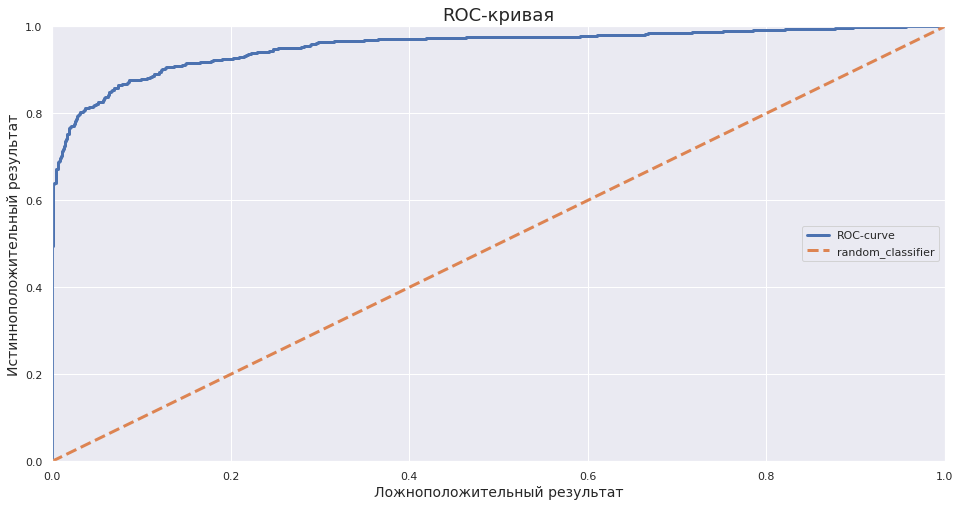

In [ ]:
def roc_curve_draw(y_test, pred_test):
    fpr, tpr, thresholds = roc_curve(y_test, pred_test)

    sns.set_style('darkgrid')
    plt.figure(figsize=(16, 8))
    plt.plot(fpr, tpr, linewidth=3, label='ROC-curve')
    plt.plot([0, 1], [0, 1], linestyle='--', linewidth=3, label='random_classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Ложноположительный результат', fontsize=14)
    plt.ylabel('Истинноположительный результат', fontsize=14)
    plt.title('ROC-кривая', fontsize=18)
    plt.legend(loc='center right')
    plt.show()
    
roc_curve_draw(y_test, model_cbc.predict_proba(X_test)[:, 1])

Проверка точности предсказаний модели - метрика качества `precision`

In [ ]:
precision = precision_score(y_test, predict.round())
'Точность предсказаний выбранной модели:', precision

('Точность предсказаний выбранной модели:', 0.8209876543209876)

Проверка полноты предсказаний модели - метрика качества `recall`

In [ ]:
print(recall_score(y_test, predict.round()))

0.854389721627409


Вычисление матрицы ошибок

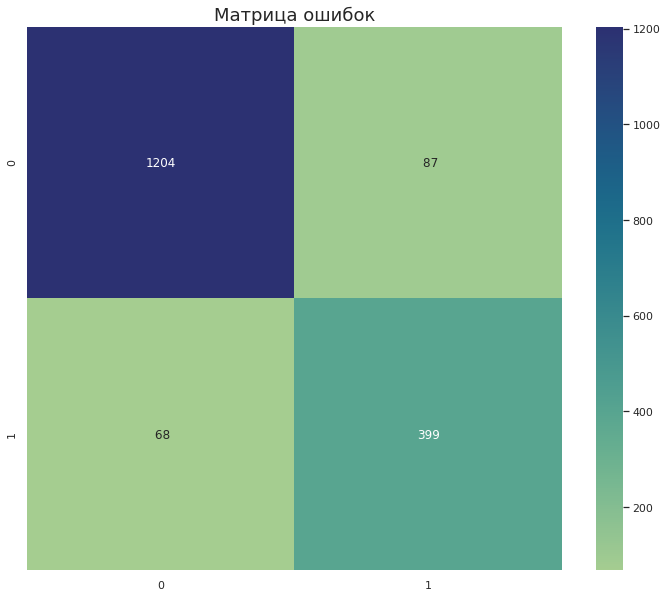

In [ ]:
sns.set_style('darkgrid')
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_matrix(y_test, predict.round()),annot=True,fmt='3.0f',cmap='crest')
plt.title('Матрица ошибок', fontsize=18)
plt.show()

Рейтинг важности признаков

In [ ]:
features_importance = (
    pd.DataFrame(data = {'feature': X_train.columns, 
                         'percent': np.round(model_cbc.feature_importances_, decimals=1)})
)
features_importance.sort_values('percent', ascending=False).reset_index(drop=True)

feature  percent
0         TotalCharges     33.8
1    contract_duration     29.2
2       MonthlyCharges     16.0
3                 Type     13.0
4      InternetService      1.4
5   internet_available      1.0
6        PaymentMethod      1.0
7      StreamingMovies      0.8
8               gender      0.7
9       OnlineSecurity      0.6
10         TechSupport      0.6
11          Dependents      0.4
12    PaperlessBilling      0.4
13        OnlineBackup      0.3
14       SeniorCitizen      0.2
15         StreamingTV      0.2
16       MultipleLines      0.2
17             Partner      0.1
18    DeviceProtection      0.1
19     phone_available      0.1

### Выводы:
- для проведения тестирования выбрана модель `CatBoostClassifier` с параметрами: 
    - `n_estimators` (`iterations`) = 700 
    - `l2_leaf_reg` = 9 
    - `max_depth` = 2
    - `learning_rate` = 0.88
- на тестовых данных результат `AUC-ROC` выбранной модели равен **0.95**
- для проверки адекватности модели результат её предсказаний был сопоставлен с результатом предсказаний `Dummy` модели и построена `ROC-кривая`. Результат `CatBoostClassifier` значительно лучше результата `Dummy` модели
- точность предсказаний модели составила - **0.82**
- полнота предсказаний - **0.85**
- матрица ошибок показывает, что модель ошибается в редких случаях
- в тройке признаков, оказавших наибольший вес при обучении, оказались: общая сумма платежей, продолжительность договора, ежемесячный платёж
- для прогнозирования оттока клиентов наиболее подходящая модель - `CatBoostClassifier`

## Отчёт по решению

После ознакомления с предоставленными заказчиком данными был составлен план для выполнения поставленной задачи. Посмотрим, насколько удалось выполнить все намеченные в нём шаги.

### Предобработка данных

Данный шаг выполнен на 100%. 
<br>Все датафреймы проверены на наличие дубликатов, в даных изменены типы, обработаны пропущенные значения, добавлены признаки, определяющие наличие подключения клиентами интернет услуг и услуг телефонии, добавлен признак, показывающий продолжительность заключённого с клиентом договора, выявлен  и вынесен целевой признак.

### Объединение датафреймов, исследование общей таблицы

Шаг выполнен на 100%. 
<br>При объединении датафреймов возникли пропуски, так как таблицы с данными об интернет услугах и о телефонии меньшего размера, чем таблица, в которой находятся данные о заключённых договорах. Пропущенные значения заменены нулями, это эквивалентно тому, что данной услугой клиент не пользовался. Построена диаграмма распределения пользователей интернета и телефона по целевому признаку, по ней видно, что среди пользователей интернета почти половина расторгла договор, среди пользователей телефонных услуг расторгла договор примерно треть клиентов. Построена тепловая диаграмма корелляции признаков `phik`. Она показывает, что у ежемесячных платежей наблюдается высокая связь с общей суммой платежей, наличием подключения к телефонии и интернет услугам, продолжительность контракта коррелирует с общей суммой платежей.

### Разделение датафрейма на выборки для обучения моделей

Шаг выполнен на 100%.
<br>Для обучения прогнозированию оттока клиентов выбраны три различные модели: Модель случайного леса, Модель линейной регрессии, Модель градиентного бустинга CatBoost. Их качество оценим метрикой `ROC-AUC` - площадь под `ROC-кривой`.
<br>Из датафрейма удалены признаки даты и ID клиентов - они помешали бы обучению. Отдельно вынесен целевой признак, все данные разделены на обучающую и тестовую выборки с учётом баланса классов в целевом признаке. Размер тестовой выборки - 25% от общего датафрейма.
<br>Признаки, оставшиеся для обучения: 
- `Type` - тип договора по периоду пролонгации;
- `PaperlessBilling` - обмен документами без бумажных носителей;
- `PaymentMethod` - способ оплаты;
- `MonthlyCharges` - ежемесячные платёж в соответствии с тарифом;
- `TotalCgarges` - общая сумма платежей;
- `gender` - информация о половой принадлежности;
- `SeniorCitizen` - информация о том, является ли клиент пенсионером;
- `Partner` - информации о том, состоит ли клиент в браке;
- `Dependents` - информация о наличии детей;
- `internet_available` - информация о польщовании интернет услугами;
- `InternetService` - тип подключения к сети интернет;
- `OnlineSecurity` - подключение услуги блокировки небезопасных сайтов;
- `OnlineBackup` - подключение облачного хранилища файлов для резервного копирования данных;
- `DeviceProtection` - подключение антивируса;
- `TechSupport` - подключение выделенной линии технической поддержки;
- `StreamingTV` - подключение стримингового телевидения;
- `StreamingMovies` - подключение каталога фильмов;
- `contract_duration` - продолжительность контракта;
- `MultipleLines` - подключение телефонного аппарата к нескольким линиям одновременно;
- `phone_available` - подключение к телефонии

### Применение техник кодирования с учётом моделей, которые будут использованы

Шаг выполнен на 100%.
<br>Из данных сделаны копии и обработаны в соответствии с требованиями каждой модели.
<br>Для корректного обучения линеной модели к данным применена техника `one-hot-encoding`и масштабирование с помощью `StandardScaler`.
<br>Для корректного обучения модели случайного леса к данным применена техника порядкового кодирования `ordinal encoding`
<br>Для обучения `CatBoost` кодирование не требуется

### Обучение моделей на тренировочной выборке (подбор гиперпараметров)

Шаг выполнен на 100%.
<br>Подбор гиперпараметров осуществлялся при помощи кросс-валидации.
<br>В обучении модели логистической регрессии подбирались гиперпараметры: регуляризация `C` и количество итераций `max_iter`, удалось получить **`ROC-AUC` = 0.83**
<br>Для модели случайного леса подбирались глубина `max_depth` и количество деревьев `n_estimators`, получена **`ROC-AUC` = 0.87**
<br>Для модели `CatBoostClassifier` были подобраны `n_estimators`, `l2_leaf_reg`, `max_depth`, `learning_rate`. Лучшее значение **`ROC-AUC` = 0.93** <br>Общее время обучения всех моделей составило около шести минут.

### Выбор оптимальной модели

Шаг выполнен на 100%.
<br>Лучшее значение `ROC-AUC` получено у модели `CatBoostClassifier` при гиперпараметрах:
- `n_estimators` (`iterations`) = 700
- `l2_leaf_reg` = 9
- `max_depth` = 2
- `learning_rate` = 0.88

### Проверка качества лучшей модели на тестовой выборке

Шаг выполнен на 100%.
<br>Проверка качества модели на тестовой выборке показала положительный результат: **`ROC-AUC` = 0.95**
<br>Для проверки адекватности модели результат её предсказаний был сопоставлен с результатом предсказаний `Dummy` модели и построена `ROC-кривая`. Результат `CatBoostClassifier` значительно лучше результата `Dummy` модели. <br>Дополнительно получены ещё две метрики модели: точность предсказаний - **`precision` = 0.82** и полнота предсказаний - **`recall` = 0.85**
<br>Построенная матрица ошибок показала, что модель ошибается в редких случаях
<br>Выявление важности признаков при помощи `feature_importances`. В тройке признаков, имевших наибольший вес при обучении, оказались: общая сумма платежей, продолжительность договора, ежемесячный платёж.

<br>**Итог: для достижения поставленной цели (прогнозирование оттока клиентов) наиболее подходящая модель - `CatBoostClassifier`**